# **Data and Dependencies Imports**

## **Mounting Drive and Dependencies Import**

In [ ]:
# 1.1 Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 1.2 Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pearsonr
import itertools
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
import plotly.express as px

Mounted at /content/drive


## **Dataset Loading**

In [ ]:
# 2.1 Load main dataset (store5.csv)
dataset = pd.read_csv('/content/drive/MyDrive/store5.csv')

# 2.2 Load holidays dataset (hols.csv)
hols = pd.read_csv('/content/drive/MyDrive/hols.csv')

# **Exploratory Data Analysis**

## **Descriptive Statistics**

In [ ]:
# Descriptive statistics of the dataset
dataset.describe()

,id,store_nbr,sales,onpromotion,dcoilwtico
count,5.557200e+04,55572.0,55572.000000,55572.000000,38379.000000
mean,1.501021e+06,5.0,280.580231,2.687864,67.925589
std,8.662894e+05,0.0,652.588149,11.748996,25.666659
min,1.452000e+03,5.0,0.000000,0.000000,26.190000
25%,7.512365e+05,5.0,1.000000,0.000000,46.380000
50%,1.501021e+06,5.0,19.000000,0.000000,53.330000
75%,2.250806e+06,5.0,237.000000,0.000000,95.800000
max,3.000590e+06,5.0,8216.620000,182.000000,110.620000


## **Line Plot of Sales Over Time**

In [ ]:
# Sort by store number and date to visualize the sales trend
fig = px.line(dataset.sort_values(["store_nbr", "date"]), x='date', y='sales', title="Sales over Time")
fig.show()

## **Handling Missing Dates**

In [ ]:
# Check for missing/null values in the dataset
missing_values = dataset.isnull().sum()
print("Missing Values in each column:\n", missing_values)

Missing Values in each column:
 id                 0
date               0
store_nbr          0
family             0
sales              0
onpromotion        0
dcoilwtico     17193
dtype: int64


In [ ]:
# Find missing dates and add them with sales set to 0 (only for dates before 2017)
# Convert 'date' column to datetime format
dataset['date'] = pd.to_datetime(dataset['date'])

# Create a complete date range from the earliest to latest date in the dataset
full_dates = pd.date_range(start=dataset['date'].min(), end='2016-12-31')

# Find missing dates by comparing with the full date range
missing_dates = full_dates.difference(dataset['date'])

# Create a DataFrame for missing dates with sales set to 0
missing_data = pd.DataFrame({'date': missing_dates, 'sales': 0})

# Add missing rows to the original dataset and sort it
dataset = pd.concat([dataset, missing_data]).sort_values('date').reset_index(drop=True)

## **Handle Missing Oil Values**

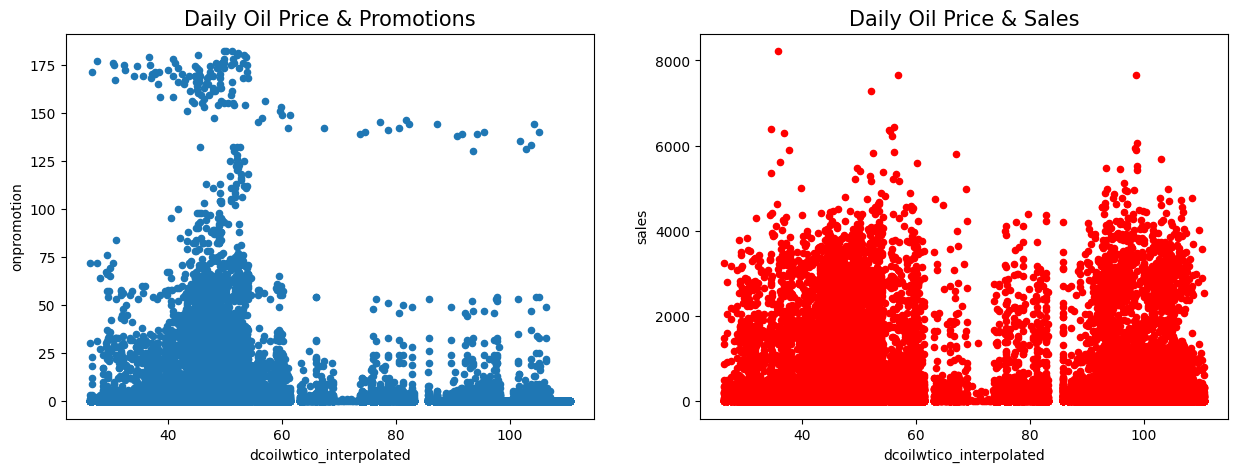

In [ ]:
# Handle missing values in 'dcoilwtico' by interpolation
dataset['dcoilwtico'] = dataset['dcoilwtico'].replace(0, np.nan)  # Replace 0 with NaN if needed
dataset['dcoilwtico_interpolated'] = dataset['dcoilwtico'].interpolate()

# Create scatter plots to visualize relationships
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot for daily oil price vs promotions
dataset.plot.scatter(x="dcoilwtico_interpolated", y="onpromotion", ax=axes[0])
axes[0].set_title('Daily Oil Price & Promotions', fontsize=15)

# Scatter plot for daily oil price vs sales
dataset.plot.scatter(x="dcoilwtico_interpolated", y="sales", ax=axes[1], color="r")
axes[1].set_title('Daily Oil Price & Sales', fontsize=15)

# Show the plots
plt.show()

## **Outlier Checking**

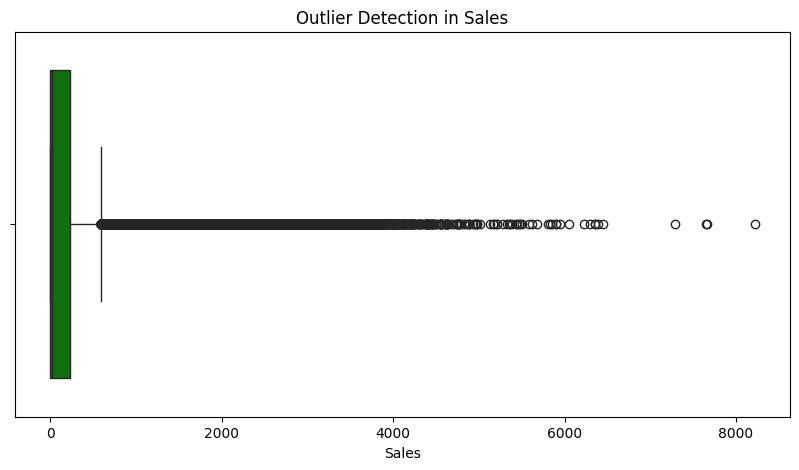

In [ ]:
# Boxplot for Outlier Detection in Sales
plt.figure(figsize=(10, 5))

# Boxplot for Sales
sns.boxplot(x=dataset['sales'], color='green')
plt.title('Outlier Detection in Sales')
plt.xlabel('Sales')

# Show the plot
plt.show()

## **Holiday Status Addition**

In [ ]:
# Ensure both 'date' columns are in datetime format
dataset['date'] = pd.to_datetime(dataset['date'])
hols['Date'] = pd.to_datetime(hols['Date'])

# Create a 'hols_status' column in the dataset, default as 'Non-Holiday'
dataset['hols_status'] = 'Non-Holiday'

# For matching dates in the holidays dataset, set 'hols_status' to 'Holiday'
dataset.loc[dataset['date'].isin(hols['Date']), 'hols_status'] = 'Holiday'

# Check if the holiday status has been added correctly
dataset[['date', 'sales', 'hols_status']].head()

,date,sales,hols_status
0,2013-01-01,0.0,Holiday
1,2013-01-01,0.0,Holiday
2,2013-01-01,0.0,Holiday
3,2013-01-01,0.0,Holiday
4,2013-01-01,0.0,Holiday


# **Sales Data Visualization**

## **Overall Sales by Time**

### **Overall Sales during Holiday**

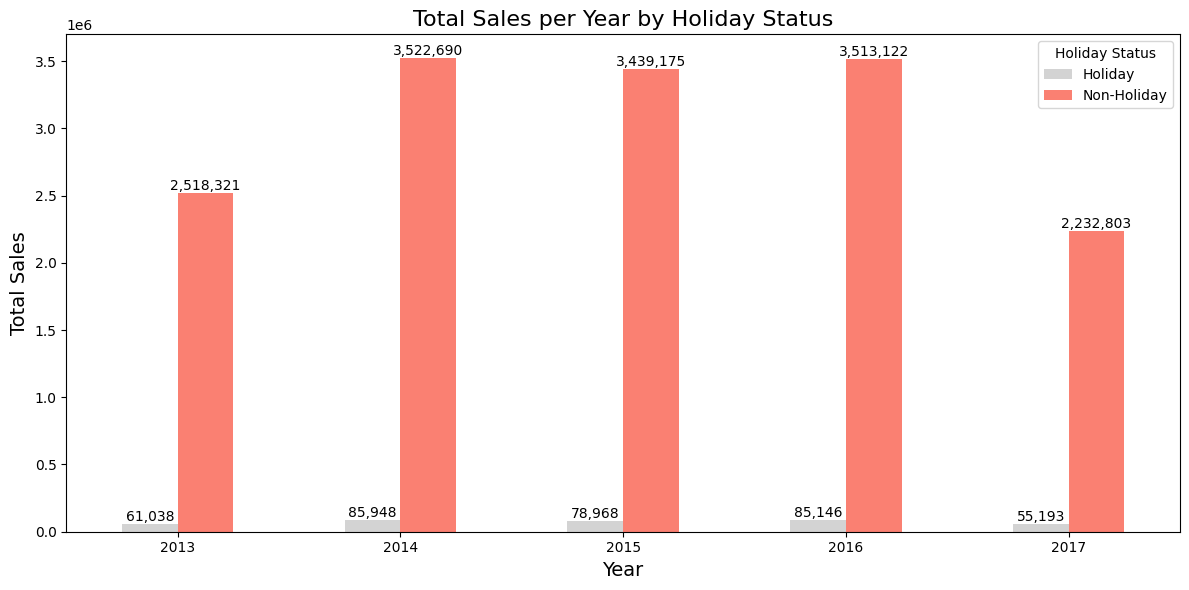

In [ ]:
# Group by year and holiday status, summing sales
yearly_sales_by_holiday = dataset.groupby([dataset['date'].dt.year, 'hols_status'])['sales'].sum().unstack()

# Create the bar plot
ax = yearly_sales_by_holiday.plot(kind='bar', color=['lightgray', 'salmon'], figsize=(12, 6))

# Add data labels above the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=10)

# Customize titles and labels
plt.title('Total Sales per Year by Holiday Status', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)

# Rotate x-axis labels to horizontal
plt.xticks(rotation=0)

plt.legend(title='Holiday Status')

# Remove gridlines
ax.grid(False)

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

### **Overal Sales Yearly**

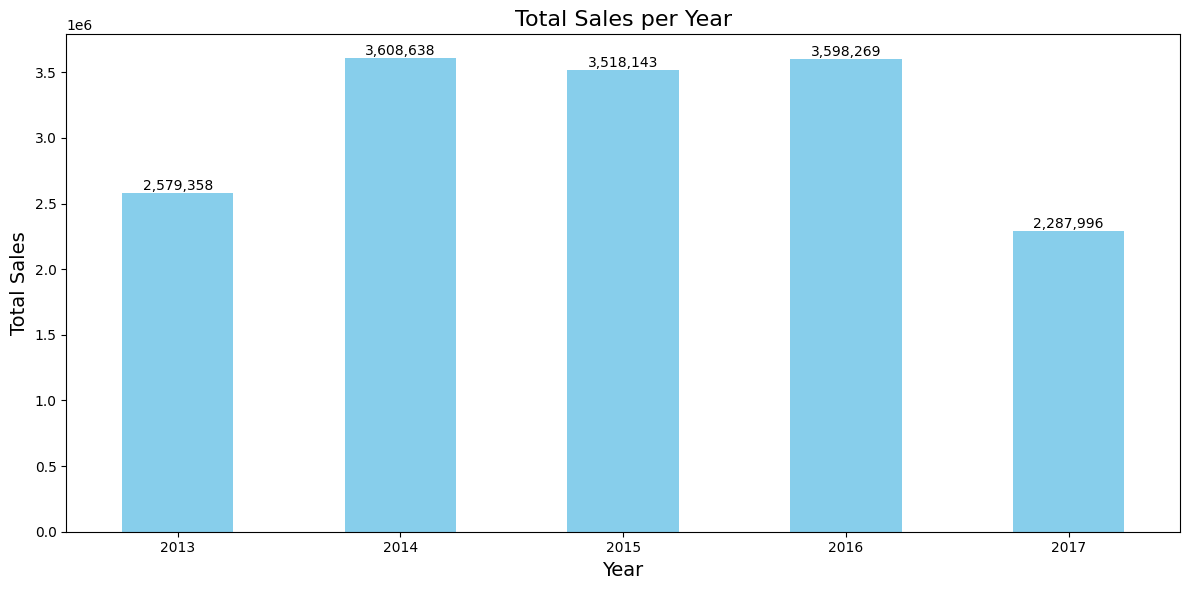

In [ ]:
# Group by year and sum sales
yearly_sales = dataset.groupby(dataset['date'].dt.year)['sales'].sum()

# Create the bar plot
plt.figure(figsize=(12, 6))
ax = yearly_sales.plot(kind='bar', color='skyblue')

# Add data labels above the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=10)

# Customize titles and labels
plt.title('Total Sales per Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)

# Rotate x-axis labels to horizontal
plt.xticks(rotation=0)

# Remove gridlines
ax.grid(False)

plt.tight_layout()
plt.show()

### **Overall Sales Quarterly**

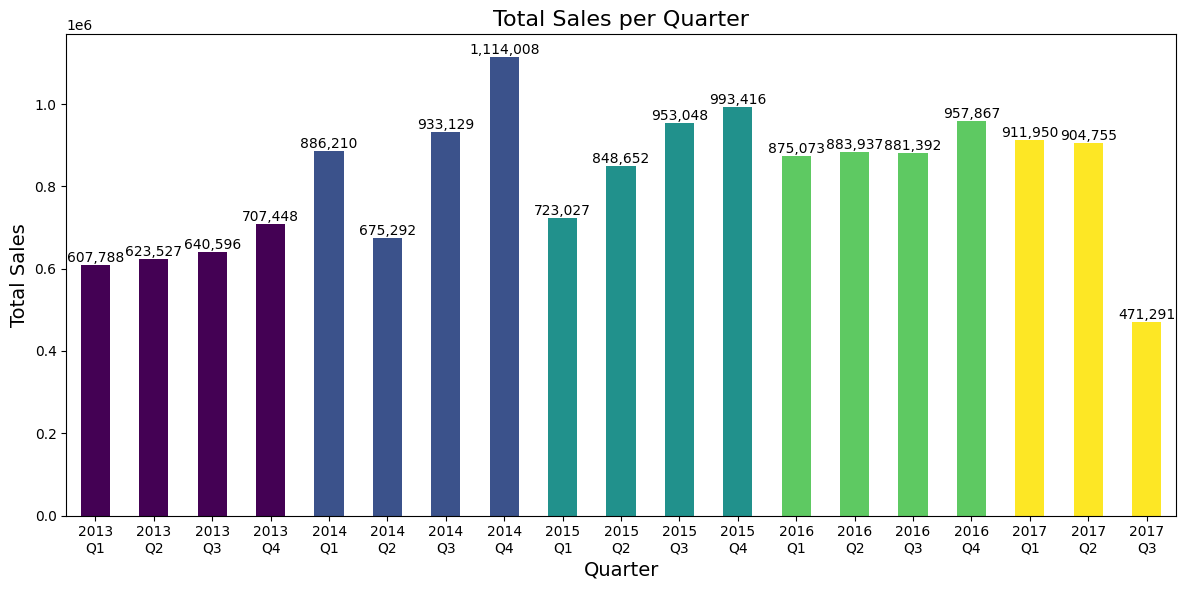

In [ ]:
# Group by quarter and sum sales
quarterly_sales = dataset.groupby(dataset['date'].dt.to_period("Q"))['sales'].sum()

# Define a color map for each year
unique_years = quarterly_sales.index.year.unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_years)))  # Use a colormap for different colors

# Create a dictionary to map years to colors
color_map = {year: colors[i] for i, year in enumerate(unique_years)}

# Create the bar plot
plt.figure(figsize=(12, 6))
ax = quarterly_sales.plot(kind='bar', color=[color_map[q.year] for q in quarterly_sales.index])

# Add data labels above the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=10)

# Customize titles and labels
plt.title('Total Sales per Quarter', fontsize=16)
plt.xlabel('Quarter', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)

# Rotate x-axis labels and format them
formatted_labels = [f"{str(q).split('Q')[0]}\nQ{str(q).split('Q')[1]}" for q in quarterly_sales.index]
ax.set_xticklabels(formatted_labels, rotation=0)

# Remove gridlines
ax.grid(False)

plt.tight_layout()
plt.show()

### **Overall Sales Monthly**

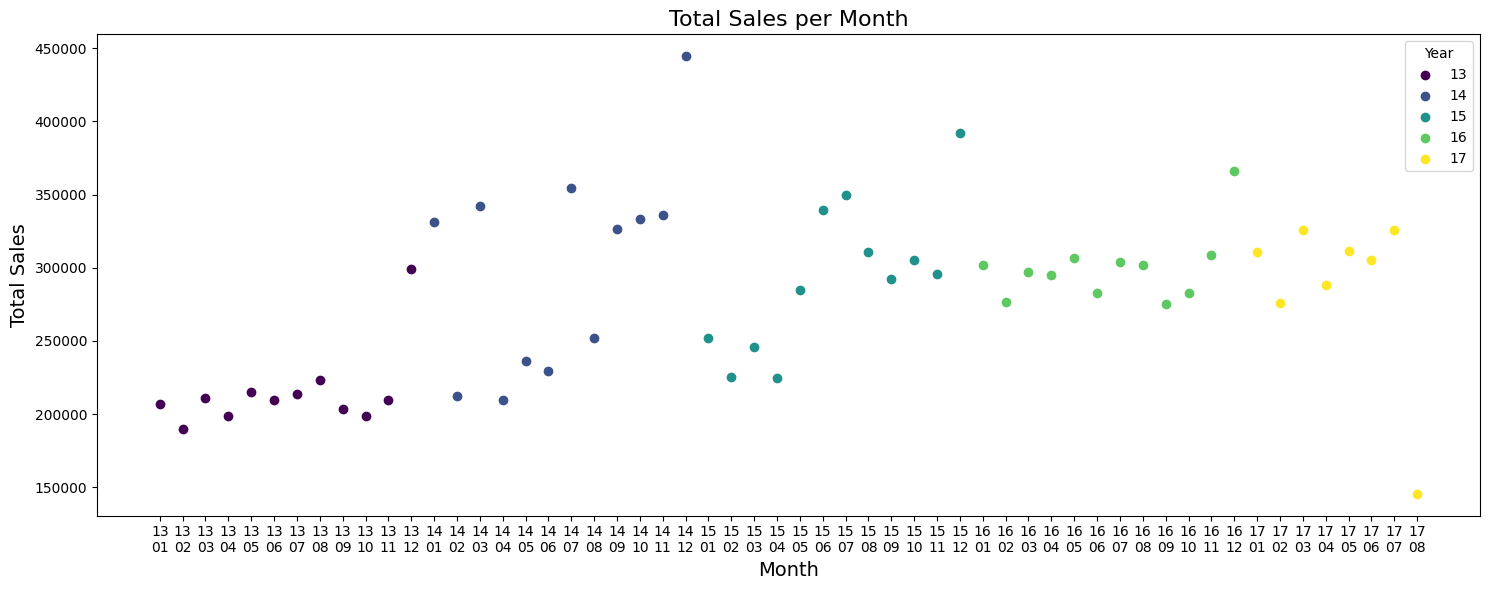

In [ ]:
# Group by month and sum sales
monthly_sales = dataset.groupby(dataset['date'].dt.to_period("M"))['sales'].sum()

# Create a DataFrame to handle the month and year for color coding
monthly_sales_df = monthly_sales.reset_index()
monthly_sales_df['year'] = monthly_sales_df['date'].dt.year

# Create the figure with a wider width
plt.figure(figsize=(15, 6))  # Adjusted width for better accommodation of labels

# Unique years for color coding
unique_years = monthly_sales_df['year'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_years)))  # Use a colormap for different colors

# Plot only the dots for each year with different colors
for i, year in enumerate(unique_years):
    year_data = monthly_sales_df[monthly_sales_df['year'] == year]
    plt.scatter(year_data['date'].astype(str), year_data['sales'], marker='o', color=colors[i], label=str(year)[2:])  # Use last two digits for year

# Customize titles and labels
plt.title('Total Sales per Month', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)

# Format x-axis labels to show two-digit year and month on separate lines
formatted_labels = [f"{str(m).split('-')[0][2:]}\n{str(m).split('-')[1]}" for m in monthly_sales_df['date']]
plt.xticks(ticks=range(len(formatted_labels)), labels=formatted_labels, rotation=0)

# Add legend
plt.legend(title='Year')

# Remove gridlines
plt.grid(False)

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

## **Categorical Product Sales by Time**

### **Categorical Product Yearly Sales**

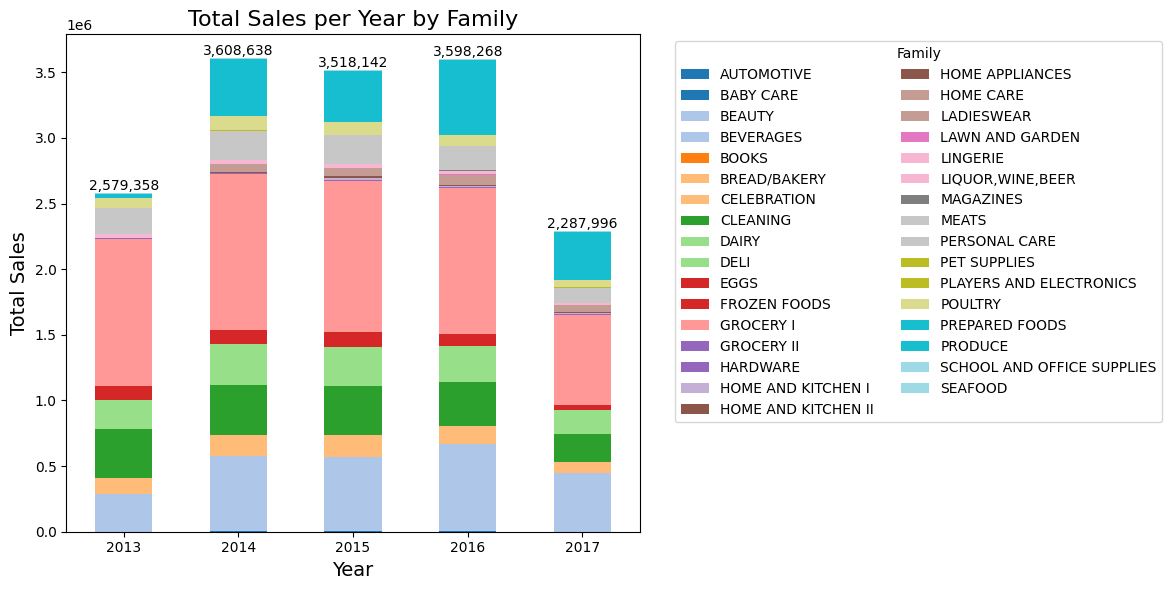

In [ ]:
# Yearly Sales by Family
yearly_sales_by_family = dataset.groupby([dataset['date'].dt.year, 'family'])['sales'].sum().unstack()

# Create the bar plot
ax = yearly_sales_by_family.plot(kind='bar', stacked=True, figsize=(12, 6), cmap='tab20')
plt.title('Total Sales per Year by Family', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)

# Add a single data label above each year's total sales with comma separation
total_sales = yearly_sales_by_family.sum(axis=1)
for i, total in enumerate(total_sales):
    ax.annotate(f'{int(total):,}',  # Format total with commas
                xy=(i, total),
                ha='center', va='bottom', fontsize=10)

# Set the legend at the right in two columns
plt.legend(title='Family', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)

# Remove gridlines
plt.grid(False)

# Set x-ticks to be horizontal
plt.xticks(rotation=0)

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


### **Categorical Product Quarterly Sales**

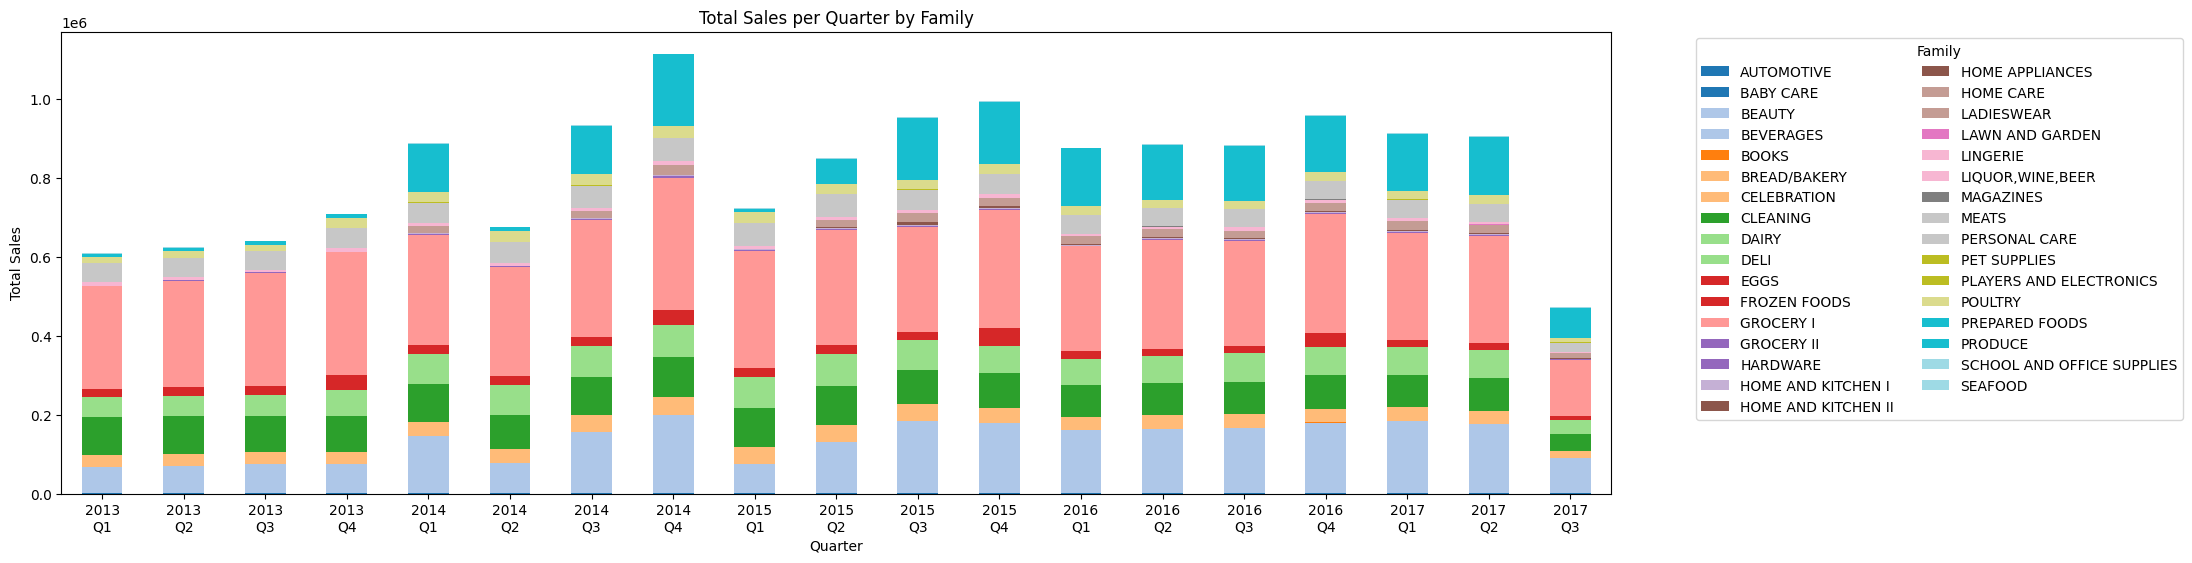

In [ ]:
# Assuming 'dataset' is your DataFrame and is already defined
quarterly_sales_by_family = dataset.groupby([dataset['date'].dt.to_period("Q"), 'family'])['sales'].sum().unstack()

# Plotting
ax = quarterly_sales_by_family.plot(kind='bar', stacked=True, figsize=(20, 6), cmap='tab20')

plt.title('Total Sales per Quarter by Family')
plt.xlabel('Quarter')
plt.ylabel('Total Sales')

# Set x-ticks to be horizontal with newline for formatting
# Format the labels directly based on the period representation
quarter_labels = [f"{q.year}\nQ{q.quarter}" for q in quarterly_sales_by_family.index]
ax.set_xticklabels(quarter_labels, rotation=0)

# Update legend to have 2 columns
plt.legend(title='Family', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)

# Remove gridlines
plt.grid(False)

plt.show()


### **Categorical Product Monthly Sales**

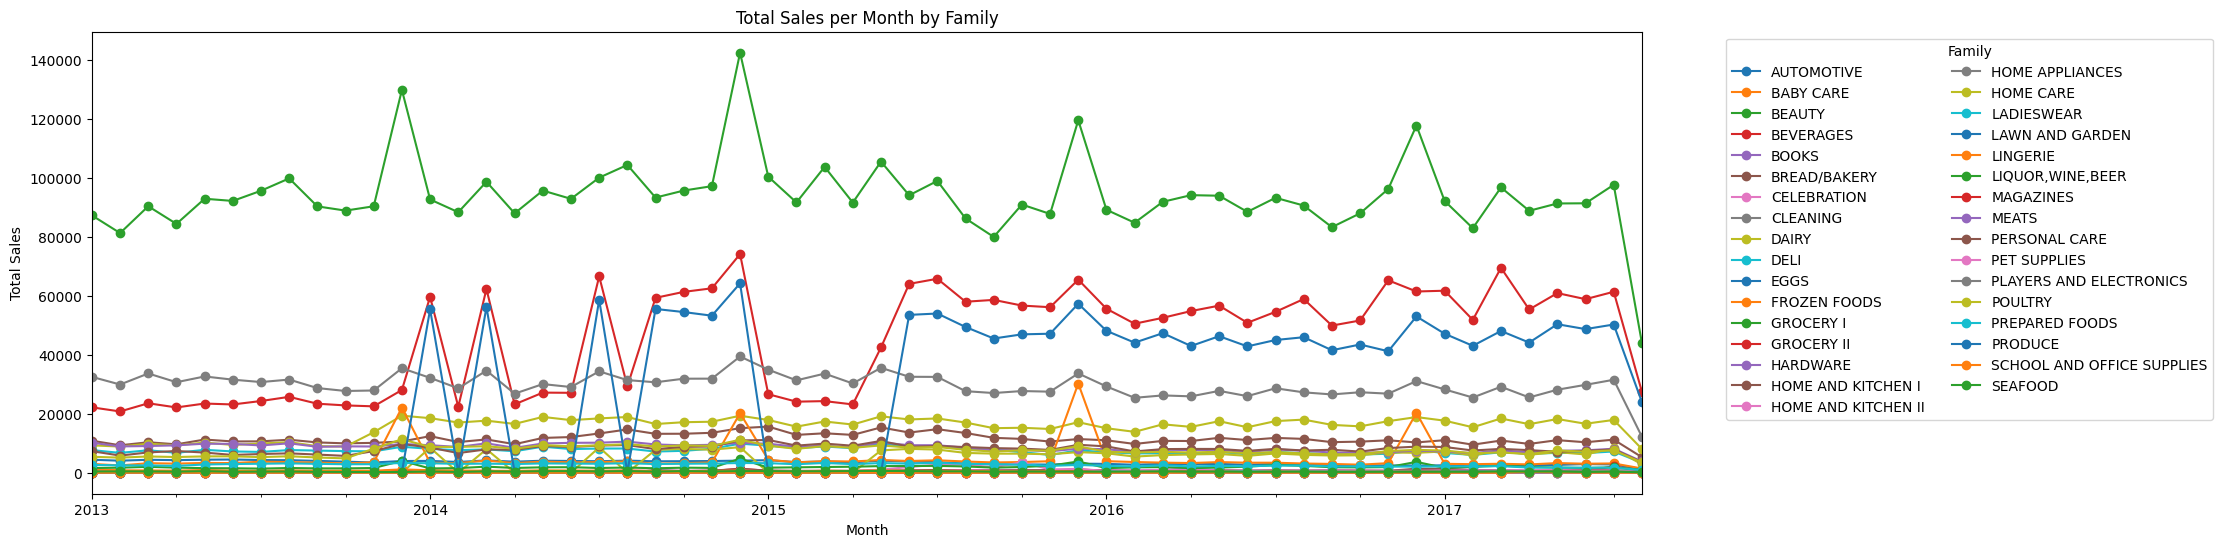

In [ ]:
monthly_sales_by_family = dataset.groupby([dataset['date'].dt.to_period("M"), 'family'])['sales'].sum().unstack()

# Plotting
ax = monthly_sales_by_family.plot(kind='line', marker='o', figsize=(20, 6))

plt.title('Total Sales per Month by Family')
plt.xlabel('Month')
plt.ylabel('Total Sales')

# Update legend to have 2 columns
plt.legend(title='Family', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)

# Remove gridlines
plt.grid(False)

plt.show()

# **Correlation Analysis**

## **Correlation Matrix**

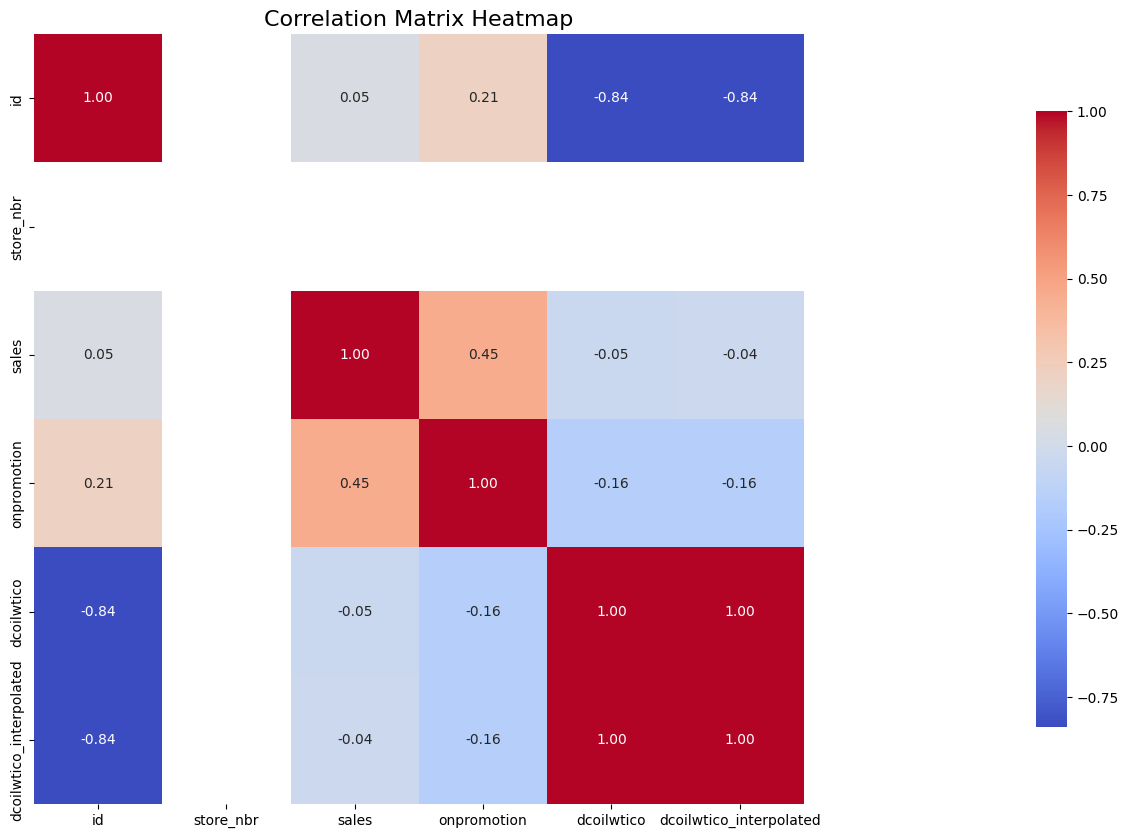

In [ ]:
# Select only numeric columns
numeric_dataset = dataset.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numeric_dataset.corr()

# Create a heatmap for the correlation matrix
plt.figure(figsize=(60, 10))  # Set width to 60 for more horizontal space
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, cbar_kws={"shrink": .8},
            xticklabels=correlation_matrix.columns,
            yticklabels=correlation_matrix.index)

# Set x-axis labels to be horizontal
plt.xticks(rotation=0)

plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.show()

## **Spearman Correlation per Family**

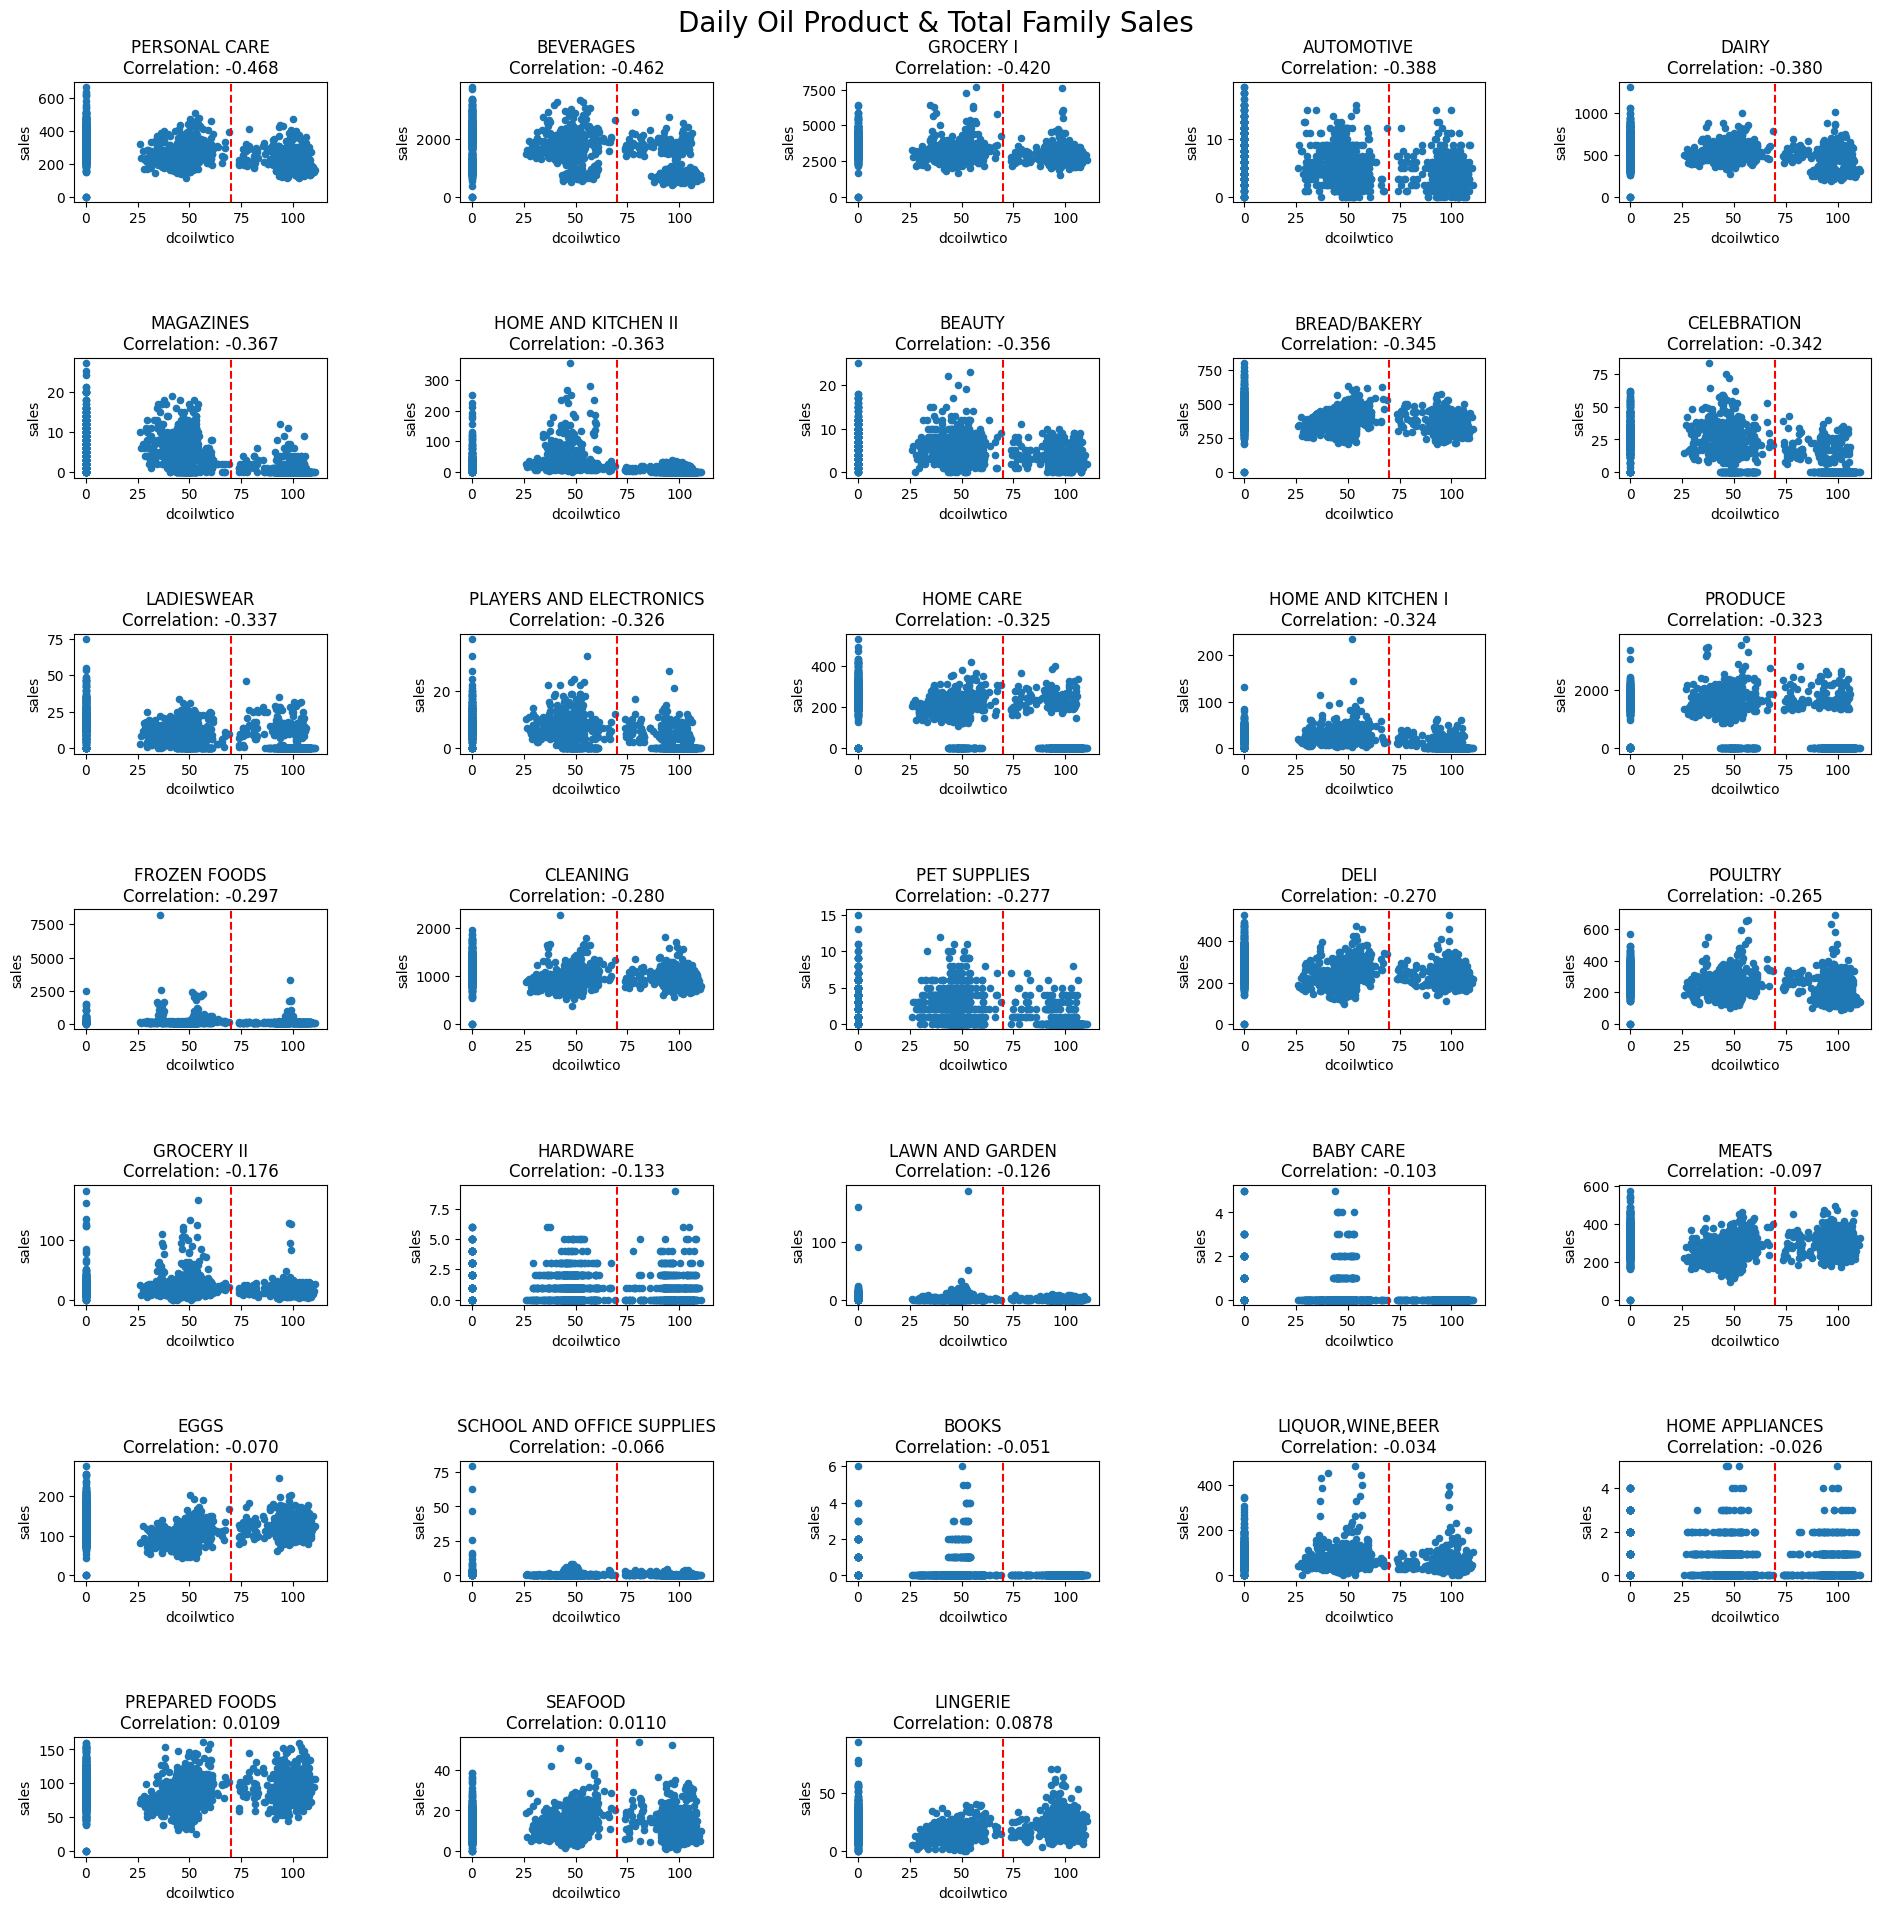

In [ ]:
# Step 1: Group by 'date' and 'family' to get the total sales per family per day
a = dataset.groupby(["date", "family"])[["sales", "dcoilwtico"]].sum().reset_index()

# Step 2: Calculate Spearman correlation for each family between 'sales' and 'dcoilwtico'
c = a.groupby("family").corr("spearman").reset_index()
c = c[c.level_1 == "dcoilwtico"][["family", "sales"]].sort_values("sales")

# Step 3: Create subplots (7 rows, 5 columns)
num_families = len(c)  # Number of families to plot
rows = (num_families + 4) // 5  # Calculate the number of rows needed

fig, axes = plt.subplots(rows, 5, figsize=(20, 20))
axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

for i, fam in enumerate(c.family):
    # Filter the data for the current family
    fam_data = a[a.family == fam]

    # Create scatter plot for current family
    fam_data.plot.scatter(x="dcoilwtico", y="sales", ax=axes[i])

    # Set the title for each subplot with family name and correlation value
    correlation = str(c[c.family == fam].sales.iloc[0])[:6]
    axes[i].set_title(f"{fam}\nCorrelation: {correlation}", fontsize=12)

    # Add a vertical line at x=70
    axes[i].axvline(x=70, color='r', linestyle='--')

# Hide any unused subplots
for j in range(num_families, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and add supertitle
plt.tight_layout(pad=5)
plt.suptitle("Daily Oil Product & Total Family Sales \n", fontsize=20)
plt.show()

## **ACF & PACF**

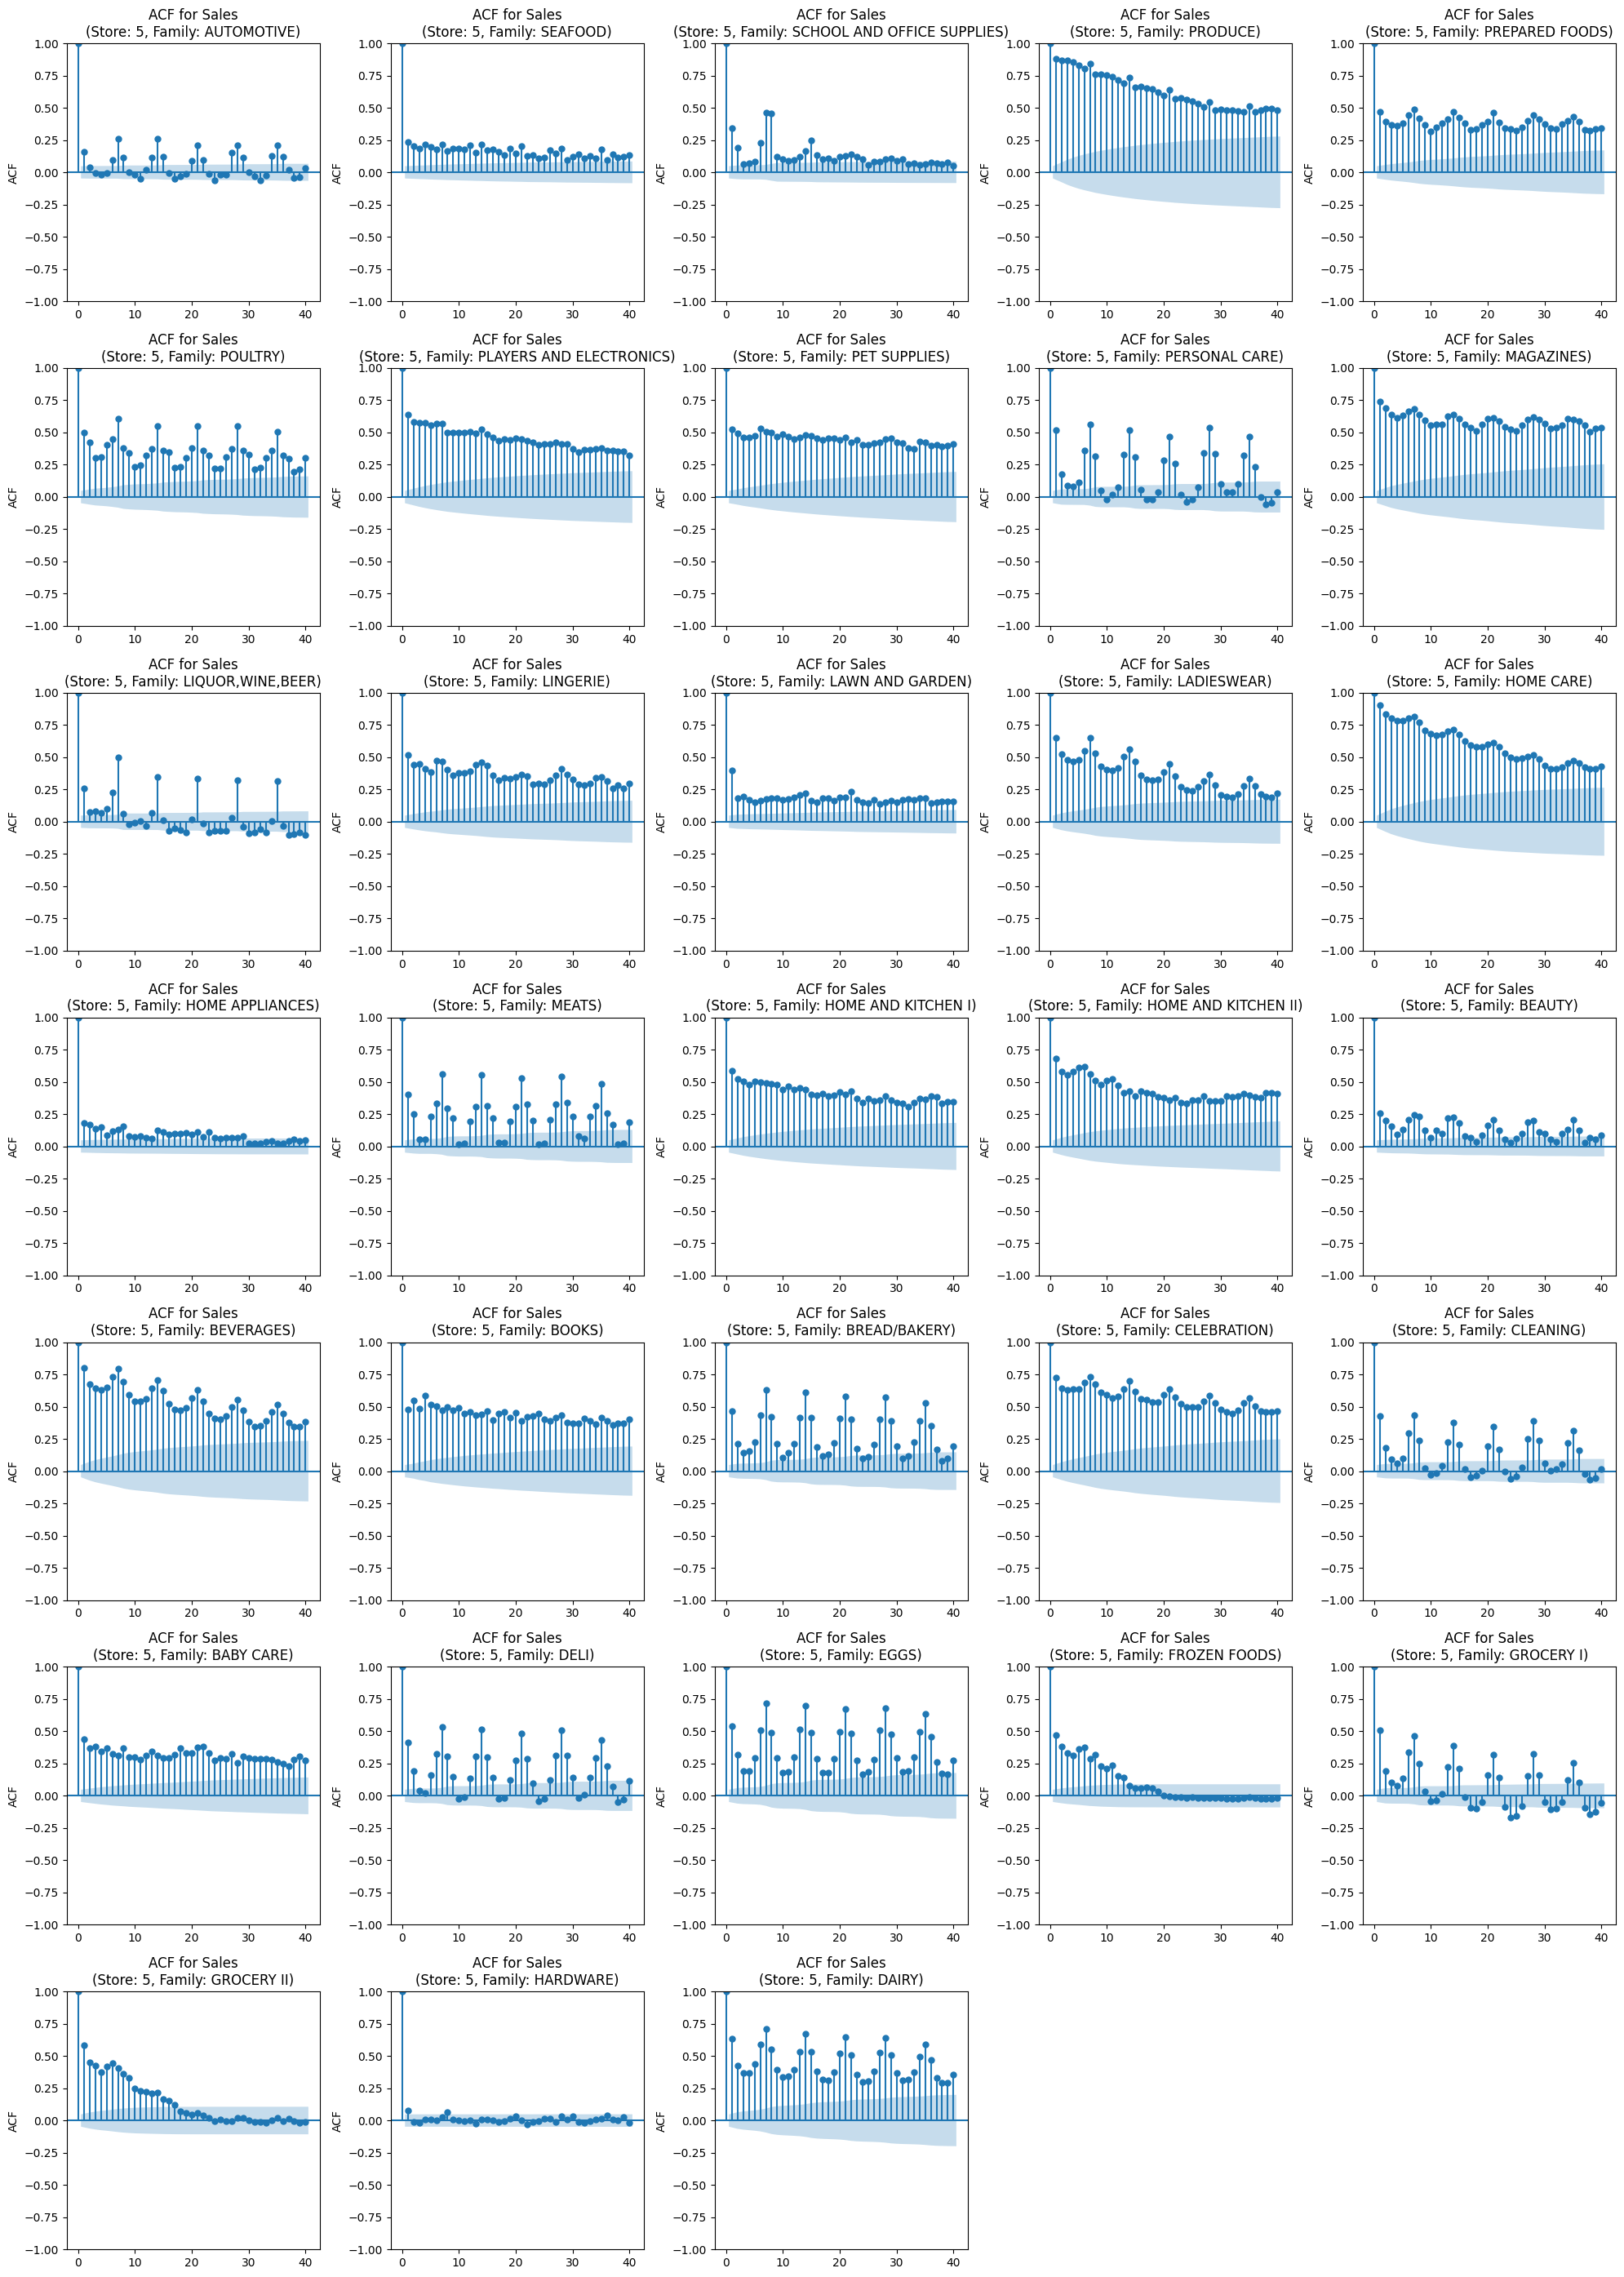

In [ ]:
# Check if there are any unique families
if unique_families.size == 0:
    raise ValueError(f"No unique family types found for the specified store: {store_id}.")

# Create subplots (5 columns)
num_families = len(unique_families)
num_cols = 5
num_rows = (num_families + num_cols - 1) // num_cols  # Calculate number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows))
axes = axes.flatten()  # Flatten to make indexing easier

# Plot ACF for each unique family type
for i, family_type in enumerate(unique_families):
    # Filter DataFrame for the specific store and family
    filtered_df = dataset[(dataset['store_nbr'] == store_id) & (dataset['family'] == family_type)]

    # Check if the filtered DataFrame has data
    if filtered_df.empty:
        axes[i].set_title(f'No sales data available for Store: {store_id}, Family: {family_type}')
        axes[i].grid(False)
        continue  # Skip to the next family if no data

    # Plot ACF
    plot_acf(filtered_df['sales'], lags=40, ax=axes[i])
    axes[i].set_title(f'ACF for Sales\n(Store: {store_id}, Family: {family_type})', fontsize=12)
    axes[i].set_ylabel('ACF', fontsize=10)

    # Remove gridlines
    axes[i].grid(False)

# Hide any unused subplots
for j in range(num_families, len(axes)):
    fig.delaxes(axes[j])

# Set x-axis label for the last subplot
axes[-1].set_xlabel('Lags', fontsize=14)

plt.tight_layout()
plt.show()

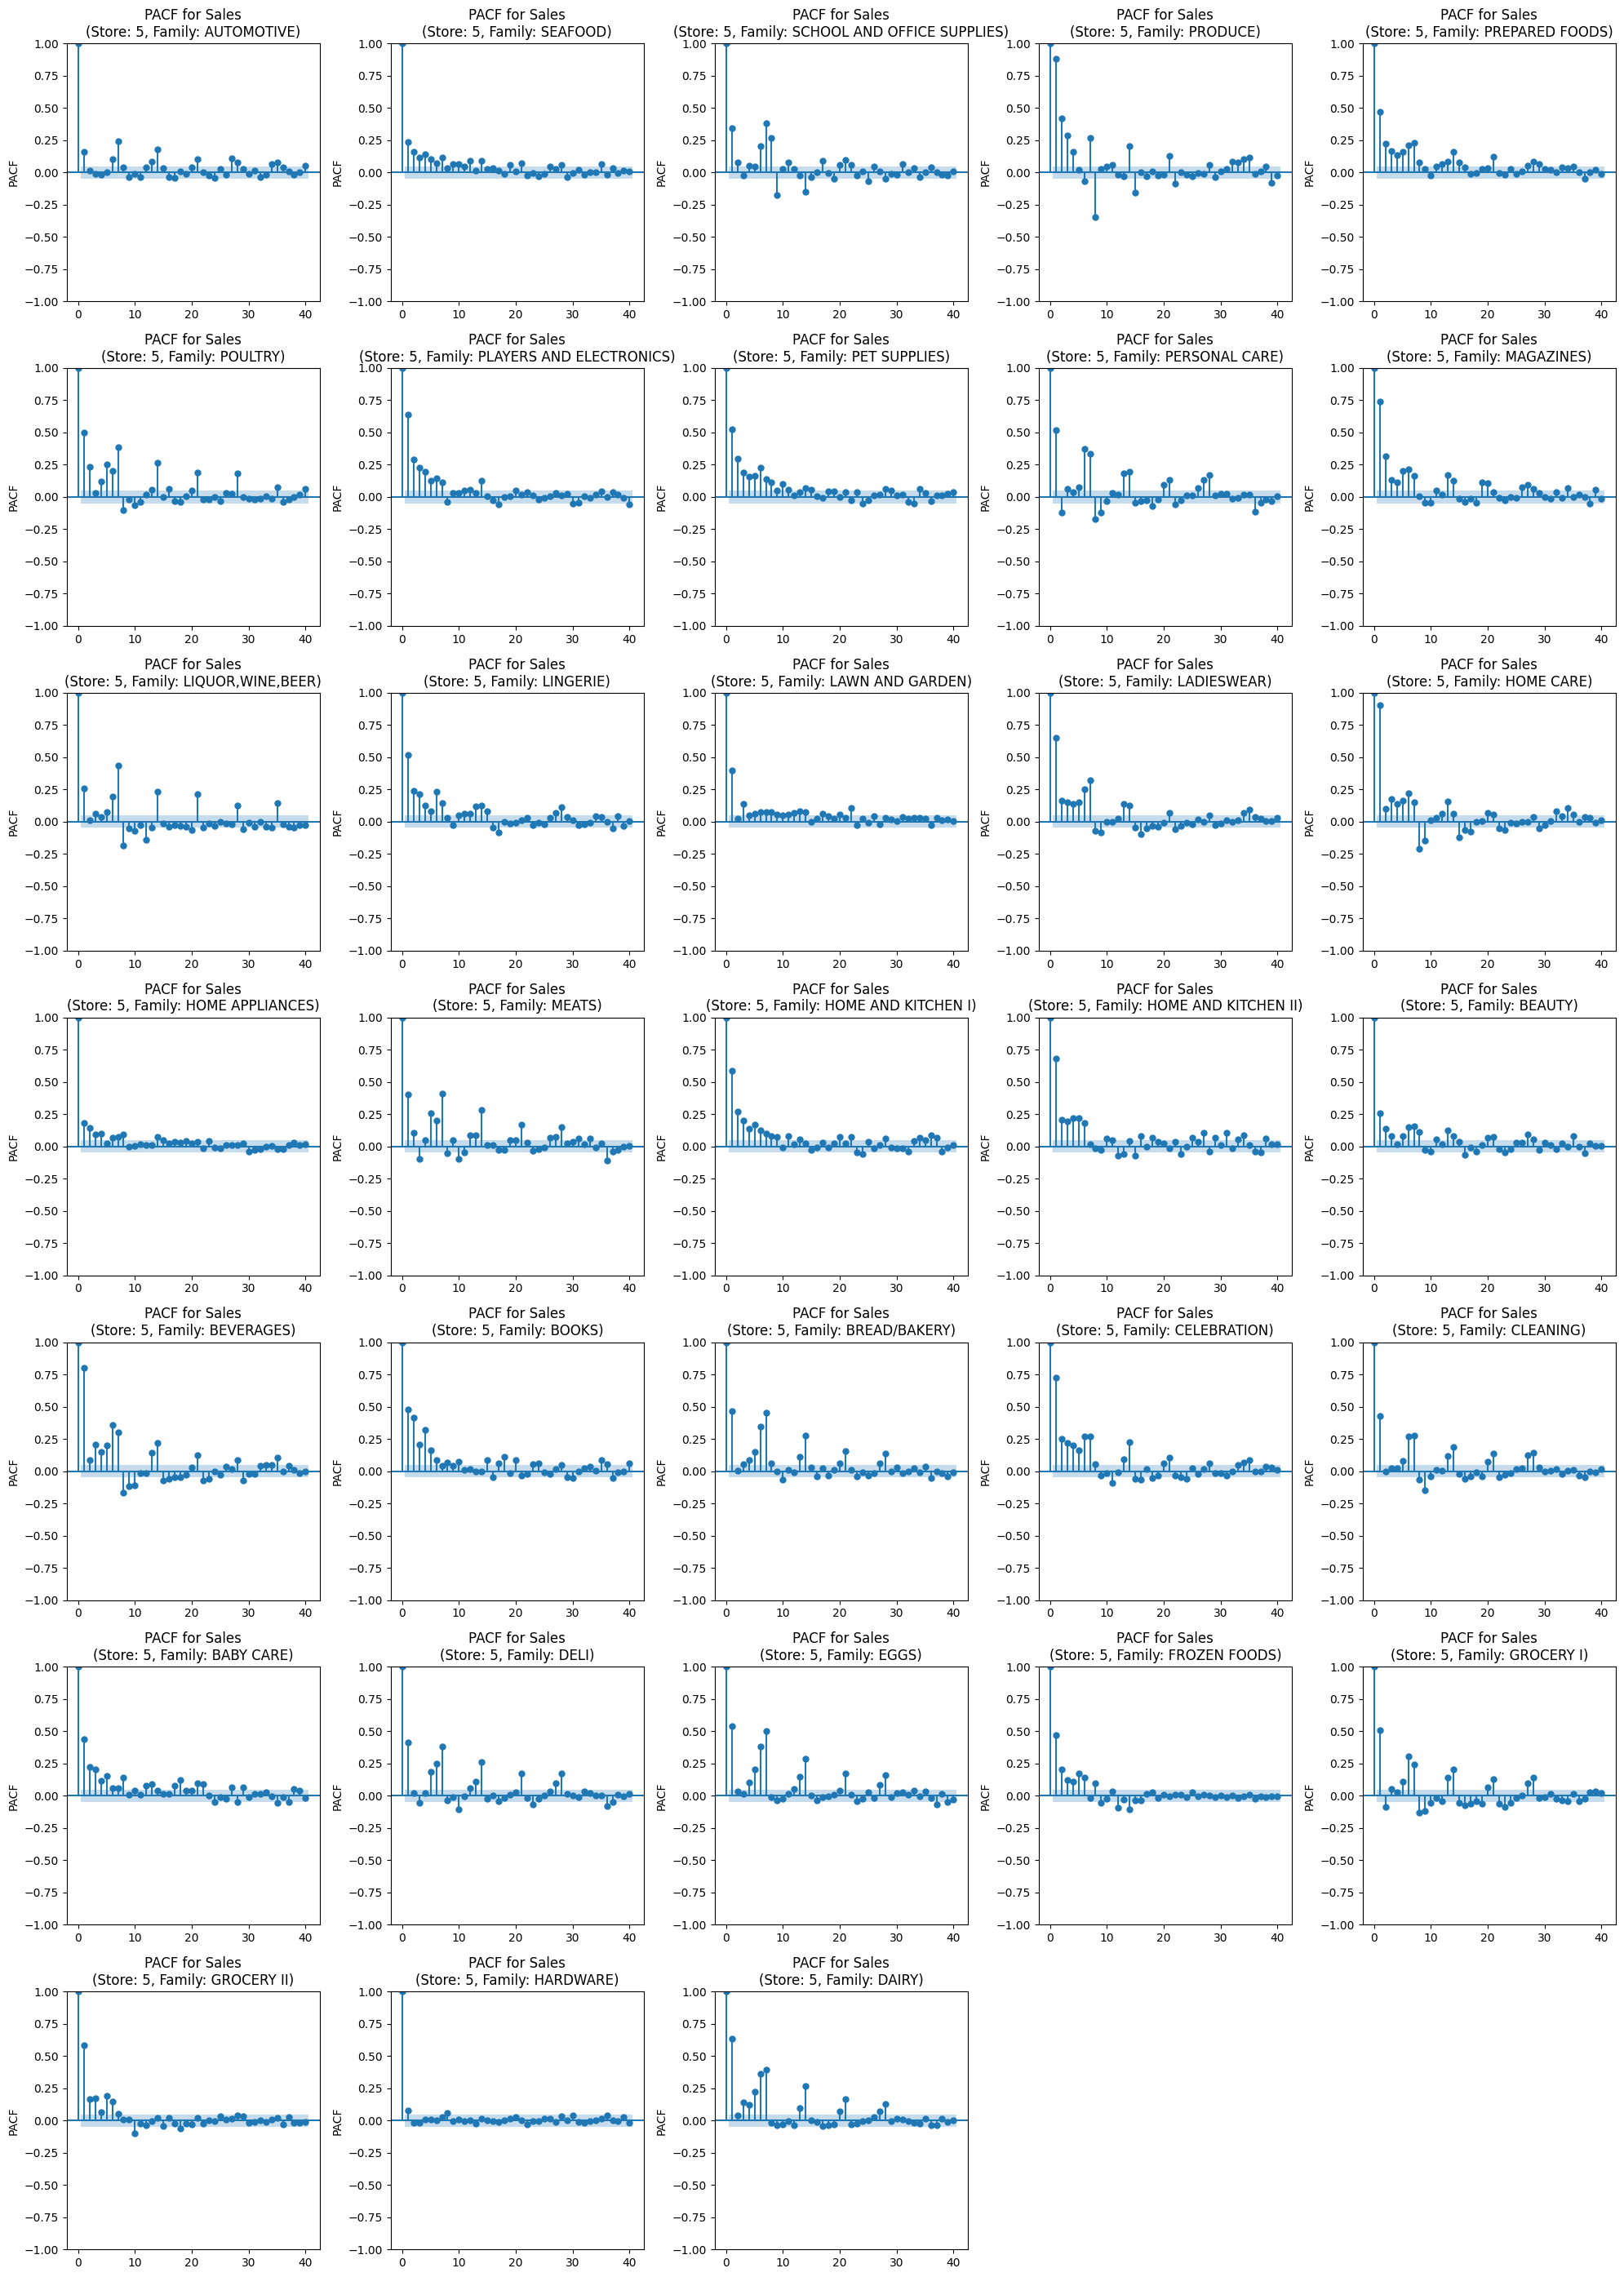

In [ ]:
# Create subplots (5 columns)
num_families = len(unique_families)
num_cols = 5
num_rows = (num_families + num_cols - 1) // num_cols  # Calculate number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows))
axes = axes.flatten()  # Flatten to make indexing easier

# Plot PACF for each unique family type
for i, family_type in enumerate(unique_families):
    # Filter DataFrame for the specific store and family
    filtered_df = dataset[(dataset['store_nbr'] == store_id) & (dataset['family'] == family_type)]

    # Check if the filtered DataFrame has data
    if filtered_df.empty:
        axes[i].set_title(f'No sales data available for Store: {store_id}, Family: {family_type}')
        axes[i].grid(False)
        continue  # Skip to the next family if no data

    # Plot PACF
    plot_pacf(filtered_df['sales'], lags=40, ax=axes[i])
    axes[i].set_title(f'PACF for Sales\n(Store: {store_id}, Family: {family_type})', fontsize=12)
    axes[i].set_ylabel('PACF', fontsize=10)

    # Remove gridlines
    axes[i].grid(False)

# Hide any unused subplots
for j in range(num_families, len(axes)):
    fig.delaxes(axes[j])

# Set x-axis label for the last subplot
axes[-1].set_xlabel('Lags', fontsize=14)

plt.tight_layout()
plt.show()


# **Dataset Split**

In [ ]:
# Step 1: Create a new DataFrame by dropping specified columns
df = dataset.drop(columns=['id', 'store_nbr', 'hols_status'])

# Step 2: Define date ranges for splitting
train_start = '2013-01-01'
train_end = '2015-12-31'
test_start = '2016-01-01'
test_end = '2016-12-31'
val_start = '2017-01-01'
val_end = '2017-12-31'

# Step 3: Train dataset (2013-2015)
train = df[(df['date'] >= train_start) & (df['date'] <= train_end)]

# Step 4: Test dataset (2016)
test = df[(df['date'] >= test_start) & (df['date'] <= test_end)]

# Step 5: Validation dataset (2017)
validation = df[(df['date'] >= val_start) & (df['date'] <= val_end)]

# Output the sizes of the splits for verification
print("Train Dataset Size:", train.shape)
print("Test Dataset Size:", test.shape)
print("Validation Dataset Size:", validation.shape)

Train Dataset Size: (36039, 6)
Test Dataset Size: (12046, 6)
Validation Dataset Size: (7491, 6)
